# Combined Evaluation Results Analysis

This notebook loads and analyzes the combined results from all evaluation batches.

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [39]:
train_scores = np.load('/scratch/gpfs/jr8867/main/contr-v1/evals/train/train_scores.npy')
train_labels = np.load('/scratch/gpfs/jr8867/main/contr-v1/evals/train/train_labels.npy')
test_scores = np.load('/scratch/gpfs/jr8867/main/contr-v1/evals/test/test_scores.npy')
test_labels = np.load('/scratch/gpfs/jr8867/main/contr-v1/evals/test/test_labels.npy')

print(f"Loaded {len(train_scores)} samples in train set")
print(f"Loaded {len(test_scores)} samples in test set")

Loaded 2634900 samples in train set
Loaded 878300 samples in test set


## Score Distribution Analysis

In [40]:
# Create a DataFrame for easier analysis
train_results_df = pd.DataFrame({
    'score': train_scores,
    'label': train_labels.astype(int)
})
test_results_df = pd.DataFrame({
    'score': test_scores,
    'label': test_labels.astype(int)
})

# Add a category column for better visualization
train_results_df['category'] = train_results_df['label'].map({0: 'Non-homolog', 1: 'Homolog'})
test_results_df['category'] = test_results_df['label'].map({0: 'Non-homolog', 1: 'Homolog'})

# Display summary statistics
print(train_results_df.groupby('category')['score'].describe())
print("-="*100)
print(test_results_df.groupby('category')['score'].describe())

                 count      mean       std  min       25%       50%       75%  \
category                                                                        
Homolog      1129339.0  2.341104  1.358010  0.0  1.389248  2.217839  3.143402   
Non-homolog  1505561.0  5.458872  2.560636  0.0  3.664959  5.314720  7.033823   

                   max  
category                
Homolog      14.044398  
Non-homolog  25.948368  
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
                count      mean       std  min       25%       50%       75%  \
category                                                                       
Homolog      179722.0  2.813341  1.677123  0.0  1.634225  2.680233  3.828523   
Non-homolog  698578.0  6.561420  2.744158  0.0  4.698405  6.260202  8.057995   

                   max  
category                
Hom

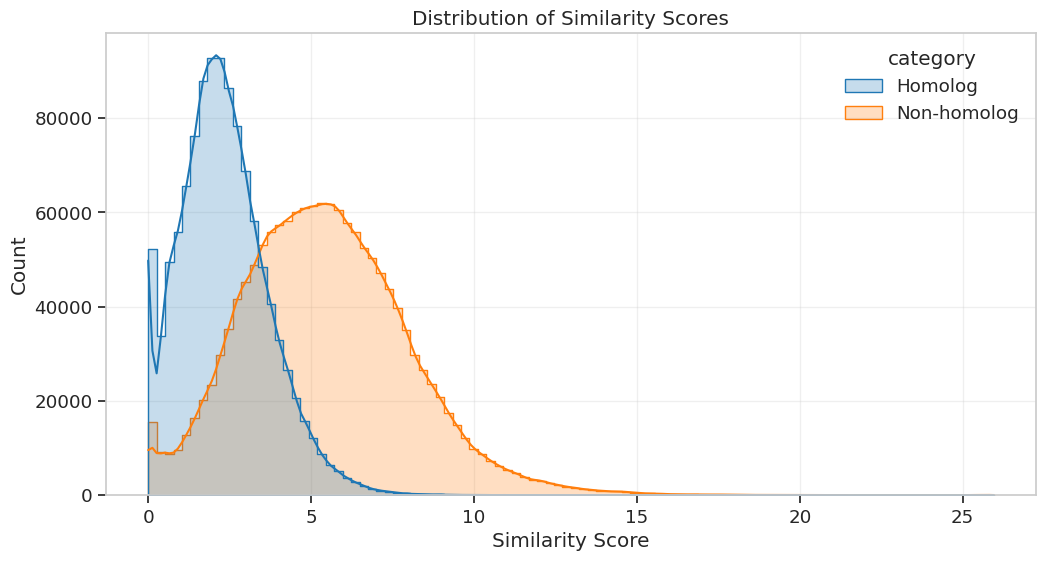

In [41]:
# Plot score distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=train_results_df, x='score', hue='category', bins=100, kde=True, element='step')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join('/scratch/gpfs/jr8867/main/contr-v1/evals/train/', 'score_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

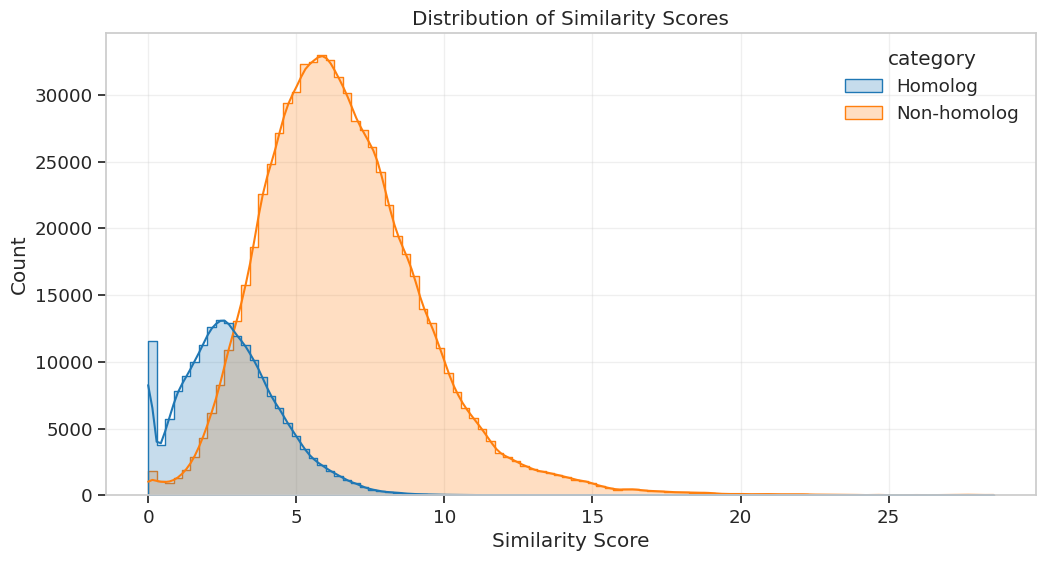

In [42]:
# Plot score distributions
plt.figure(figsize=(12, 6))
sns.histplot(data=test_results_df, x='score', hue='category', bins=100, kde=True, element='step')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join('/scratch/gpfs/jr8867/main/contr-v1/evals/test/', 'score_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

## ROC Curve Analysis

In [43]:
# Negate scores since lower scores indicate closer matches
negated_train_scores = -train_scores

# Calculate ROC curve and AUC
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, negated_train_scores)
train_roc_auc = auc(train_fpr, train_tpr)

# Find optimal threshold using Youden's J statistic
train_j_scores = train_tpr - train_fpr
train_optimal_idx = np.argmax(train_j_scores)
train_optimal_threshold = train_thresholds[train_optimal_idx]
train_optimal_metrics = {
    'tpr': train_tpr[train_optimal_idx],
    'fpr': train_fpr[train_optimal_idx],
    'threshold': train_optimal_threshold
}

# Calculate precision and recall
train_precision, train_recall, train_pr_thresholds = precision_recall_curve(train_labels, negated_train_scores)
train_avg_precision = average_precision_score(train_labels, negated_train_scores)

# Calculate F1 score at optimal threshold
y_pred = (negated_train_scores >= train_optimal_threshold).astype(int)
train_optimal_metrics['f1_score'] = f1_score(train_labels, y_pred)
train_optimal_metrics['precision'] = precision_score(train_labels, y_pred)

print(f"ROC AUC: {train_roc_auc:.4f}")
print(f"Average Precision: {train_avg_precision:.4f}")
print(f"Optimal threshold (Youden's J): {train_optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  TPR (Sensitivity): {train_optimal_metrics['tpr']:.4f}")
print(f"  FPR: {train_optimal_metrics['fpr']:.4f}")
print(f"  Precision: {train_optimal_metrics['precision']:.4f}")
print(f"  F1 Score: {train_optimal_metrics['f1_score']:.4f}")

ROC AUC: 0.8662
Average Precision: 0.7731
Optimal threshold (Youden's J): -3.7427
At this threshold:
  TPR (Sensitivity): 0.8544
  FPR: 0.2609
  Precision: 0.7107
  F1 Score: 0.7759


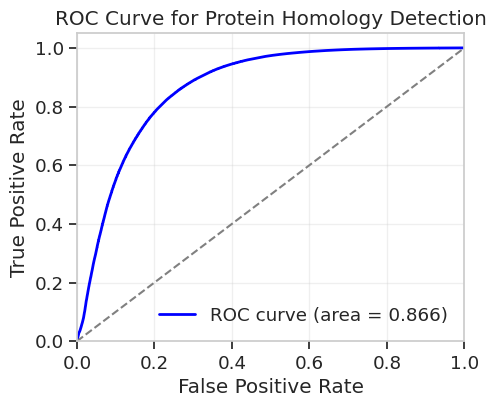

In [44]:
# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'ROC curve (area = {train_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Protein Homology Detection')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
# Save ROC plot
plt.show()


In [45]:
# Negate scores since lower scores indicate closer matches
negated_test_scores = -test_scores

# Calculate ROC curve and AUC
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, negated_test_scores)
test_roc_auc = auc(test_fpr, test_tpr)

# Find optimal threshold using Youden's J statistic
test_j_scores = test_tpr - test_fpr
test_optimal_idx = np.argmax(test_j_scores)
test_optimal_threshold = test_thresholds[test_optimal_idx]
test_optimal_metrics = {
    'tpr': test_tpr[test_optimal_idx],
    'fpr': test_fpr[test_optimal_idx],
    'threshold': test_optimal_threshold
}

# Calculate precision and recall
test_precision, test_recall, test_pr_thresholds = precision_recall_curve(test_labels, negated_test_scores)
test_avg_precision = average_precision_score(test_labels, negated_test_scores)

# Calculate F1 score at optimal threshold
y_pred = (negated_test_scores >= test_optimal_threshold).astype(int)
test_optimal_metrics['f1_score'] = f1_score(test_labels, y_pred)
test_optimal_metrics['precision'] = precision_score(test_labels, y_pred)

print(f"ROC AUC: {test_roc_auc:.4f}")
print(f"Average Precision: {test_avg_precision:.4f}")
print(f"Optimal threshold (Youden's J): {test_optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  TPR (Sensitivity): {test_optimal_metrics['tpr']:.4f}")
print(f"  FPR: {test_optimal_metrics['fpr']:.4f}")
print(f"  Precision: {test_optimal_metrics['precision']:.4f}")
print(f"  F1 Score: {test_optimal_metrics['f1_score']:.4f}")

ROC AUC: 0.8941
Average Precision: 0.6921
Optimal threshold (Youden's J): -4.3515
At this threshold:
  TPR (Sensitivity): 0.8289
  FPR: 0.2011
  Precision: 0.5147
  F1 Score: 0.6350


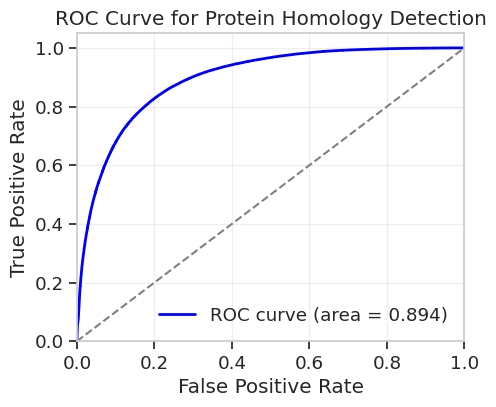

In [46]:
# Plot ROC curve
plt.figure(figsize=(5, 4))
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label=f'ROC curve (area = {test_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Protein Homology Detection')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
# Save ROC plot
plt.show()


## Precision-Recall Curve Analysis

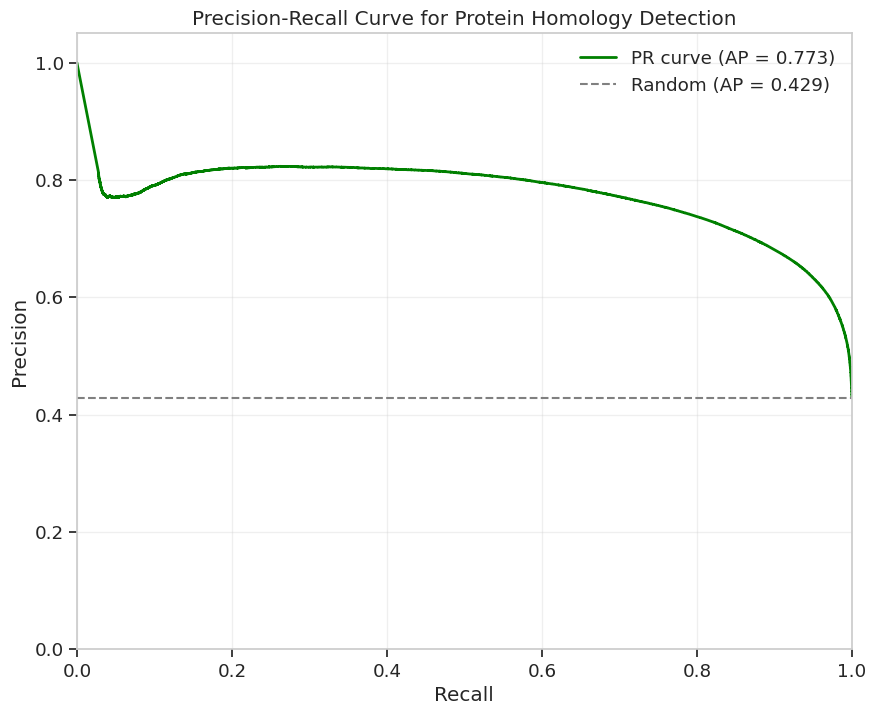

In [47]:
# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(train_recall, train_precision, color='green', lw=2, label=f'PR curve (AP = {train_avg_precision:.3f})')

# Calculate baseline (random classifier)
train_baseline = np.sum(train_labels) / len(train_labels)
plt.axhline(y=train_baseline, color='gray', linestyle='--', label=f'Random (AP = {train_baseline:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Protein Homology Detection')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

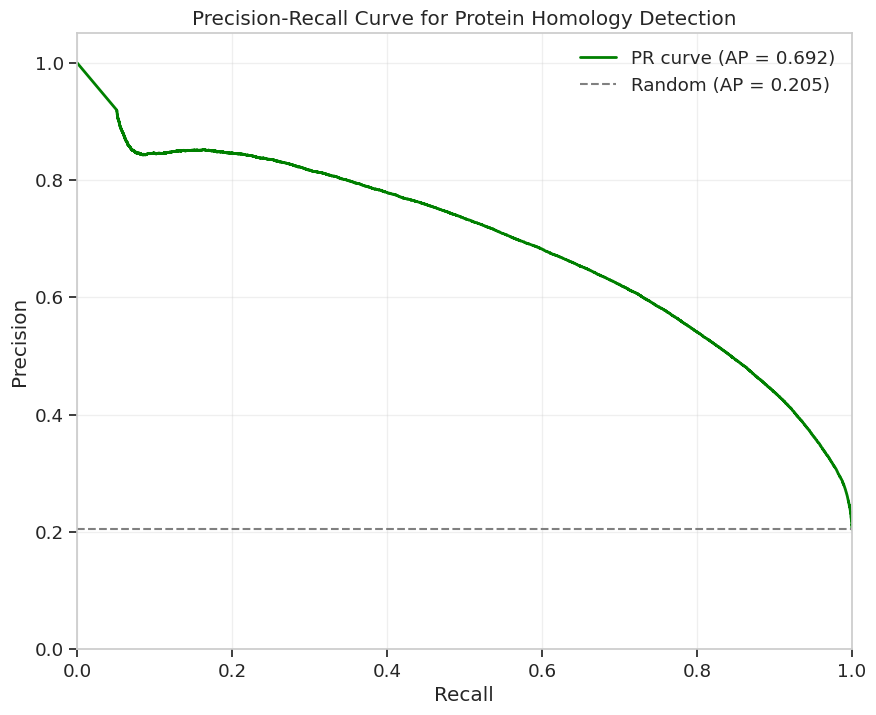

In [48]:
# Plot PR curve
plt.figure(figsize=(10, 8))
plt.plot(test_recall, test_precision, color='green', lw=2, label=f'PR curve (AP = {test_avg_precision:.3f})')

# Calculate baseline (random classifier)
test_baseline = np.sum(test_labels) / len(test_labels)
plt.axhline(y=test_baseline, color='gray', linestyle='--', label=f'Random (AP = {test_baseline:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Protein Homology Detection')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

## Optimal Threshold Analysis

In [49]:
# Create separate DataFrames for ROC and PR metrics
train_roc_df = pd.DataFrame({
    'threshold': train_thresholds,
    'fpr': train_fpr,
    'tpr': train_tpr
})

train_pr_df = pd.DataFrame({
    'threshold': train_pr_thresholds,
    'precision': train_precision[:-1],  # Precision-recall curve has one more point than thresholds
    'recall': train_recall[:-1]
})

# Calculate F1 scores for the PR curve data
train_pr_df['f1_score'] = 2 * (train_pr_df['precision'] * train_pr_df['recall']) / (train_pr_df['precision'] + train_pr_df['recall'] + 1e-10)

# Calculate Youden's J statistic using ROC data
train_roc_df['youden_j'] = train_roc_df['tpr'] - train_roc_df['fpr']

# Find optimal threshold based on Youden's J statistic
train_optimal_idx = train_roc_df['youden_j'].idxmax()
train_optimal_threshold = train_roc_df.loc[train_optimal_idx, 'threshold']
train_optimal_metrics = train_roc_df.loc[train_optimal_idx]

# Find closest threshold in PR data to get corresponding precision/recall
train_closest_pr_idx = (np.abs(train_pr_df['threshold'] - train_optimal_threshold)).idxmin()
train_optimal_pr_metrics = train_pr_df.loc[train_closest_pr_idx]

print(f"Optimal threshold (Youden's J): {train_optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  TPR (Sensitivity): {train_optimal_metrics['tpr']:.4f}")
print(f"  FPR: {train_optimal_metrics['fpr']:.4f}")
print(f"  Precision: {train_optimal_pr_metrics['precision']:.4f}")
print(f"  F1 Score: {train_optimal_pr_metrics['f1_score']:.4f}")

# For subsequent cells, use roc_df instead of threshold_df
train_threshold_df = train_roc_df

Optimal threshold (Youden's J): -3.7427
At this threshold:
  TPR (Sensitivity): 0.8544
  FPR: 0.2609
  Precision: 0.7107
  F1 Score: 0.7759


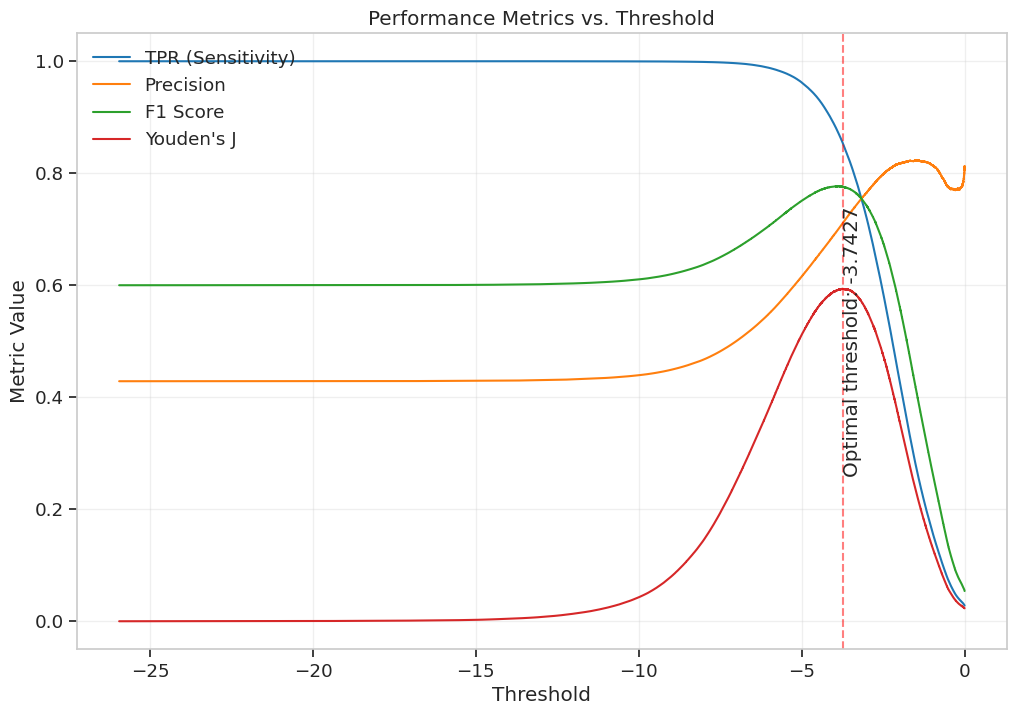

In [50]:
# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(train_threshold_df['threshold'], train_threshold_df['tpr'], label='TPR (Sensitivity)')
# Use train_pr_df for precision and f1_score since they're not in train_threshold_df (which is train_roc_df)
plt.plot(train_pr_df['threshold'], train_pr_df['precision'], label='Precision')
plt.plot(train_pr_df['threshold'], train_pr_df['f1_score'], label='F1 Score')
plt.plot(train_threshold_df['threshold'], train_threshold_df['youden_j'], label="Youden's J")

# Mark optimal threshold
plt.axvline(x=train_optimal_threshold, color='red', linestyle='--', alpha=0.5)
plt.text(train_optimal_threshold + 0.02, 0.5, f'Optimal threshold: {train_optimal_threshold:.4f}', 
         rotation=90, verticalalignment='center')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()

In [51]:
# Create separate DataFrames for ROC and PR metrics
test_roc_df = pd.DataFrame({
    'threshold': test_thresholds,
    'fpr': test_fpr,
    'tpr': test_tpr
})

test_pr_df = pd.DataFrame({
    'threshold': test_pr_thresholds,
    'precision': test_precision[:-1],  # Precision-recall curve has one more point than thresholds
    'recall': test_recall[:-1]
})

# Calculate F1 scores for the PR curve data
test_pr_df['f1_score'] = 2 * (test_pr_df['precision'] * test_pr_df['recall']) / (test_pr_df['precision'] + test_pr_df['recall'] + 1e-10)

# Calculate Youden's J statistic using ROC data
test_roc_df['youden_j'] = test_roc_df['tpr'] - test_roc_df['fpr']

# Find optimal threshold based on Youden's J statistic
test_optimal_idx = test_roc_df['youden_j'].idxmax()
test_optimal_threshold = test_roc_df.loc[test_optimal_idx, 'threshold']
test_optimal_metrics = test_roc_df.loc[test_optimal_idx]

# Find closest threshold in PR data to get corresponding precision/recall
test_closest_pr_idx = (np.abs(test_pr_df['threshold'] - test_optimal_threshold)).idxmin()
test_optimal_pr_metrics = test_pr_df.loc[test_closest_pr_idx]

print(f"Optimal threshold (Youden's J): {test_optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"  TPR (Sensitivity): {test_optimal_metrics['tpr']:.4f}")
print(f"  FPR: {test_optimal_metrics['fpr']:.4f}")
print(f"  Precision: {test_optimal_pr_metrics['precision']:.4f}")
print(f"  F1 Score: {test_optimal_pr_metrics['f1_score']:.4f}")

# For subsequent cells, use roc_df instead of threshold_df
test_threshold_df = test_roc_df

Optimal threshold (Youden's J): -4.3515
At this threshold:
  TPR (Sensitivity): 0.8289
  FPR: 0.2011
  Precision: 0.5147
  F1 Score: 0.6350


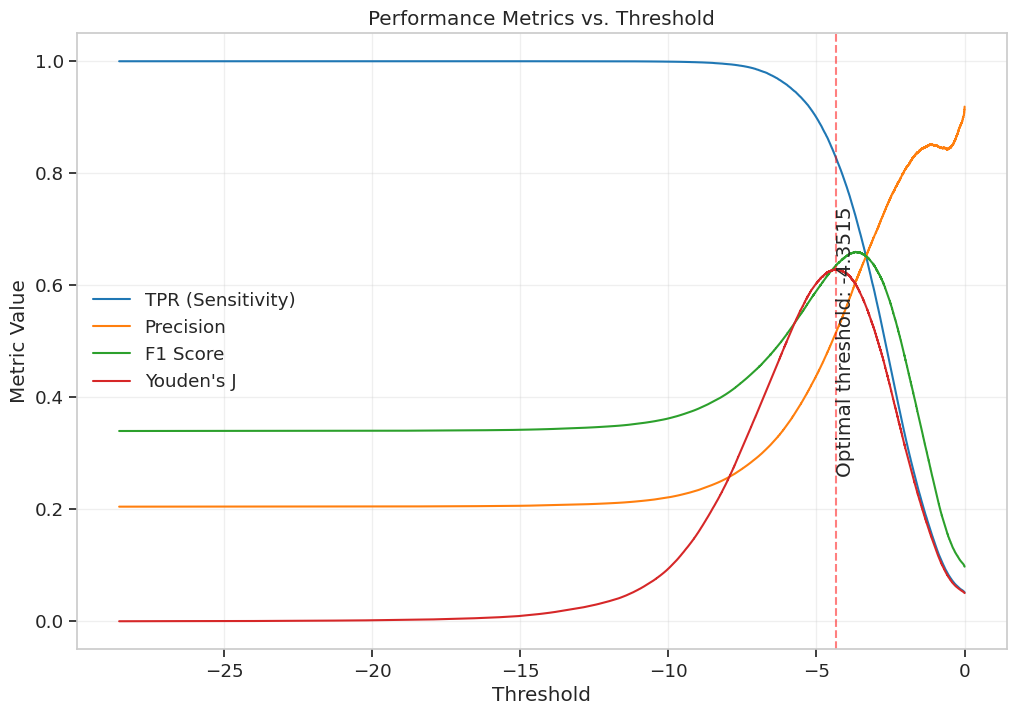

In [52]:
# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(test_threshold_df['threshold'], test_threshold_df['tpr'], label='TPR (Sensitivity)')
# Use train_pr_df for precision and f1_score since they're not in train_threshold_df (which is train_roc_df)
plt.plot(test_pr_df['threshold'], test_pr_df['precision'], label='Precision')
plt.plot(test_pr_df['threshold'], test_pr_df['f1_score'], label='F1 Score')
plt.plot(test_threshold_df['threshold'], test_threshold_df['youden_j'], label="Youden's J")

# Mark optimal threshold
plt.axvline(x=test_optimal_threshold, color='red', linestyle='--', alpha=0.5)
plt.text(test_optimal_threshold + 0.02, 0.5, f'Optimal threshold: {test_optimal_threshold:.4f}', 
         rotation=90, verticalalignment='center')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.show()

## Confusion Matrix at Optimal Threshold

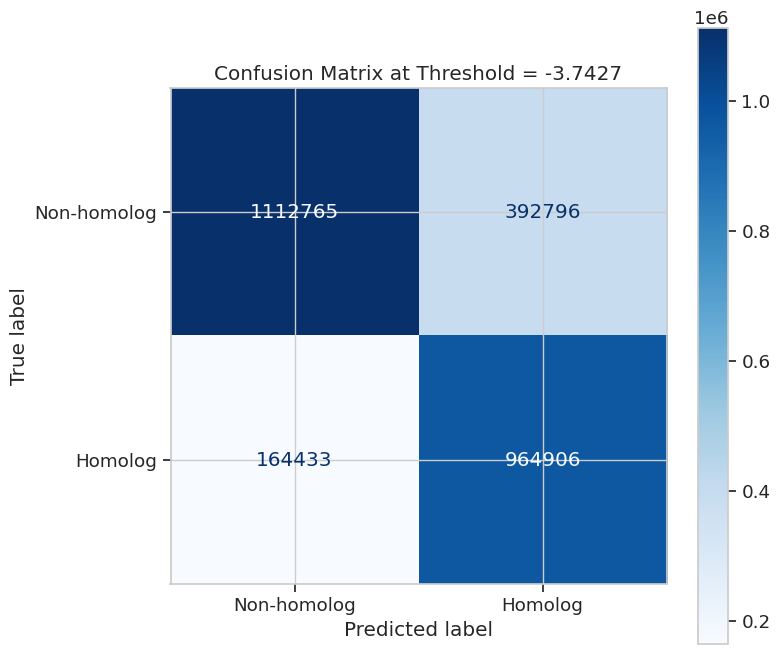

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using optimal threshold
train_y_pred = (negated_train_scores >= train_optimal_threshold).astype(int)

# Create confusion matrix
train_cm = confusion_matrix(train_labels, train_y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Non-homolog', 'Homolog'])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title(f'Confusion Matrix at Threshold = {train_optimal_threshold:.4f}')
plt.show()

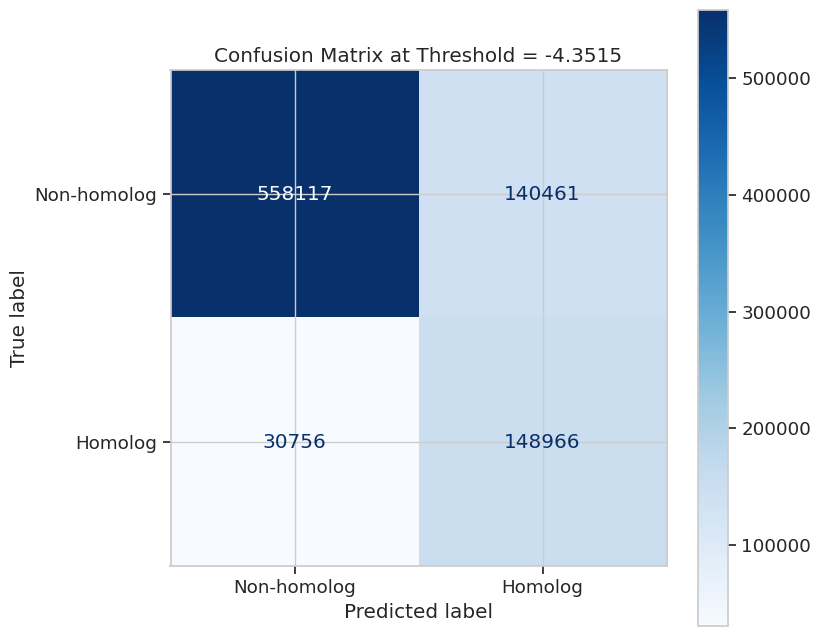

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using optimal threshold
test_y_pred = (negated_test_scores >= test_optimal_threshold).astype(int)

# Create confusion matrix
test_cm = confusion_matrix(test_labels, test_y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Non-homolog', 'Homolog'])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.title(f'Confusion Matrix at Threshold = {test_optimal_threshold:.4f}')
plt.show()

## Summary Statistics

In [55]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(train_labels, train_y_pred, target_names=['Non-homolog', 'Homolog'])
print("Train Classification Report at Optimal Threshold:")
print(report)

print("-="*100)

report = classification_report(test_labels, test_y_pred, target_names=['Non-homolog', 'Homolog'])
print("Test Classification Report at Optimal Threshold:")
print(report)

Train Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

 Non-homolog       0.87      0.74      0.80   1505561
     Homolog       0.71      0.85      0.78   1129339

    accuracy                           0.79   2634900
   macro avg       0.79      0.80      0.79   2634900
weighted avg       0.80      0.79      0.79   2634900

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Test Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

 Non-homolog       0.95      0.80      0.87    698578
     Homolog       0.51      0.83      0.64    179722

    accuracy                           0.81    878300
   macro avg       0.73      0.81      0.75    878300
weighted avg       0.86      0.81      0.82    878300

